Processing school: School A
Processing subgroup: all_pupils
Processing topic: autonomy
Processing topic: life_satisfaction
Processing topic: optimism
Processing topic: wellbeing
Processing topic: esteem
Processing topic: stress
Processing topic: appearance
Processing topic: negative
Processing topic: lonely
Processing topic: support
Processing topic: sleep
Processing topic: physical
Processing topic: free_like
Processing topic: media
Processing topic: places
Processing topic: school_belong
Processing topic: staff_relationship
Processing topic: talk
Processing topic: accept
Processing topic: home_relationship
Processing topic: home_happy
Processing topic: local_env
Error creating graph: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (0,) and arg 1 with shape (6,).
Processing topic: discrim
Processing topic: belong_local
Processing topic: wealth
Processing topic: future
Processing topic: climate
Processing topic: social
Processing top

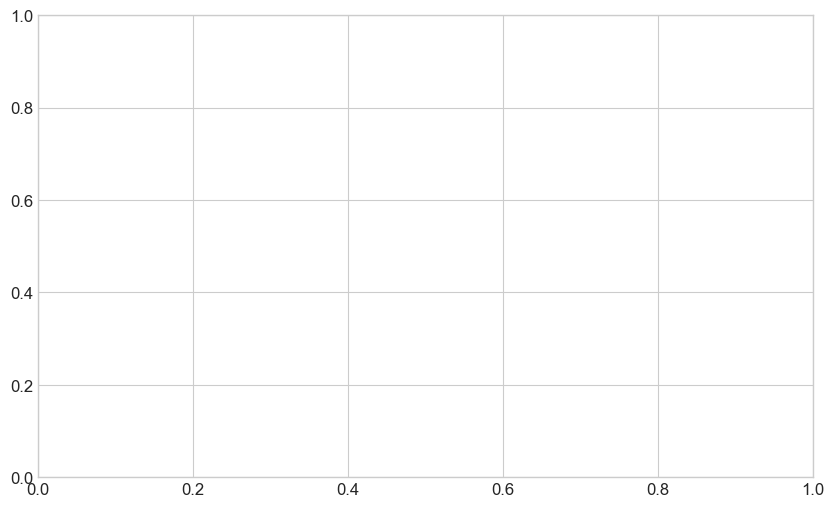

In [2]:
from typing import Literal
import pandas as pd
import ast
import matplotlib.pyplot as plt
import os
import math

SubGroups = Literal["all_pupils", "year_group", "gender", "fsm", "sen"]


def clean_master_df(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    columns_to_parse = ["cat", "cat_lab", "count", "percentage"]

    for column in columns_to_parse:
        df_copy[column] = df_copy[column].apply(lambda x: safe_parse(x, column))

    # Remove /n strings from measure_lab column (escaped)
    df_copy["measure_lab"] = df_copy["measure_lab"].str.replace("\\n", "")
    df_copy.dropna(subset=["count", "percentage"], inplace=True)
    return df_copy


def safe_parse(val, column):
    # Handle NaN values
    if isinstance(val, float) and math.isnan(val):
        return []
    # Handle empty strings
    if val == "" or val is None:
        return []
    try:
        parsed_val = ast.literal_eval(val)
        # For counts and percentages, convert elements to numbers
        if column in ["count", "percentage"] and isinstance(parsed_val, list):
            numeric_list = []
            for item in parsed_val:
                if isinstance(item, (int, float)):
                    numeric_list.append(float(item))
                elif isinstance(item, str):
                    if item == "\\N" or item.lower() == "nan":
                        numeric_list.append(0.0)
                    else:
                        try:
                            numeric_list.append(float(item))
                        except ValueError:
                            numeric_list.append(0.0)
                else:
                    numeric_list.append(0.0)
            return numeric_list
        else:
            return parsed_val
    except (ValueError, SyntaxError):
        return []  # Return empty list if parsing fails


def filter_rows_by_school(df: pd.DataFrame, school_name: str):
    df_copy = df.copy()
    df_copy = df_copy[df_copy["school_lab"] == school_name]
    return df_copy


def get_school_dfs(list_of_schools: list[str], df: pd.DataFrame):
    school_dfs = {}
    for school in list_of_schools:
        school_dfs[school] = filter_rows_by_school(df, school)
    return school_dfs


def filter_rows_by_topic(df: pd.DataFrame, topic_name: str):
    df_copy = df.copy()
    df_copy = df_copy[df_copy["group"] == topic_name]
    return df_copy


def filter_by_all_pupils(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["year_group_lab"] == "All")
        & (df_copy["gender_lab"] == "All")
        & (df_copy["fsm_lab"] == "All")
        & (df_copy["sen_lab"] == "All")
    ]
    return df_copy


def filter_by_year_group(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["year_group_lab"] == "Year 8")
        | (df_copy["year_group_lab"] == "Year 10")
    ]
    return df_copy


def filter_by_gender(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["gender_lab"] == "Girl") | (df_copy["gender_lab"] == "Boy")
    ]
    return df_copy


def filter_by_fsm(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy["fsm_lab"] == "FSM") | (df_copy["fsm_lab"] == "Non-FSM")]
    return df_copy


def filter_by_sen(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy["sen_lab"] == "SEN") | (df_copy["sen_lab"] == "Non-SEN")]
    return df_copy


def filter_rows_by_subgroup(df: pd.DataFrame, subgroup_name: SubGroups):
    if subgroup_name == "all_pupils":
        return filter_by_all_pupils(df)
    if subgroup_name == "year_group":
        return filter_by_year_group(df)
    if subgroup_name == "gender":
        return filter_by_gender(df)
    if subgroup_name == "fsm":
        return filter_by_fsm(df)
    if subgroup_name == "sen":
        return filter_by_sen(df)


def get_measures(df: pd.DataFrame):
    measures = df["measure"].unique()
    return measures


def save_graph(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(file_path, dpi=100)
    plt.close()


def single_comparison_graph(
    df: pd.DataFrame,
    measure_name: str,
    subgroup_name: str,
    topic_name: str,
    school: str,
):
    for _, data in df.iterrows():
        labels = data["cat_lab"]
        # counts = [float(x) for x in data["count"]]
        percentages = [float(x) for x in data["percentage"]]
        measure = data["measure_lab"]
        topic = data["group"]

        subgroup = subgroup_name
        # Create bar chart for percentages
        try:
            plt.figure(figsize=(10, 6))
            bars = plt.bar(labels, percentages, color="#ff7f0e", edgecolor="black")
            plt.title(
                f"{measure} - Percentages for {subgroup}", fontsize=16, fontweight="bold"
            )
            plt.xlabel("Category", fontsize=14)
            plt.ylabel("Percentage", fontsize=14)
            plt.xticks(rotation=45, ha="right", fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(
                True, which="both", linestyle="--", linewidth=0.5, color="gray", axis="y"
            )

            # Add data labels on top of the bars
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + max(percentages) * 0.01,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=12,
                )

            plt.tight_layout()
            save_graph(f"outputs/{school}/{subgroup}/{topic}/{measure}_percentages.png")
        except Exception as e:
            print(f"Error creating graph: {e}")


def make_graphs_for_single_comparison(
    df: pd.DataFrame, subgroup_name: str, topic_name: str, school: str
):
    if df.empty:
        print(f"No data for {subgroup_name} in topic {topic_name} at school {school}")
        return
    measures = get_measures(df)
    for measure in measures:
        measure_df = df[df["measure"] == measure]
        single_comparison_graph(measure_df, measure, subgroup_name, topic_name, school)


def multiple_comparison_graph(
    df: pd.DataFrame,
    measure_name: str,
    labels: list[str],
    subgroup_name: str,
    topic_name: str,
    school: str,
):
    counts_list = []
    percentages_list = []

    for label in labels:
        # Adjust the filtering to match the appropriate subgroup label columns
        if subgroup_name == "gender":
            filtered_df = df[df["gender_lab"] == label]
        elif subgroup_name == "fsm":
            filtered_df = df[df["fsm_lab"] == label]
        elif subgroup_name == "sen":
            filtered_df = df[df["sen_lab"] == label]
        elif subgroup_name == "year_group":
            filtered_df = df[df["year_group_lab"] == label]
        else:
            continue  # Skip if subgroup_name doesn't match

        if filtered_df.empty:
            counts_list.append(0)
            percentages_list.append(0)
        else:
            counts = filtered_df["count"].values[0]
            percentages = filtered_df["percentage"].values[0]

            # Ensure counts and percentages are numeric
            counts = [float(x) for x in counts]
            percentages = [float(x) for x in percentages]

            counts_list.append(sum(counts))
            percentages_list.append(sum(percentages))

    measure = measure_name
    topic = topic_name
    subgroup = subgroup_name

    # Create bar chart for percentages
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, percentages_list, color="#ff7f0e", edgecolor="black")
    plt.title(
        f"{measure} - Percentage Comparison for {subgroup}",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel(subgroup.capitalize(), fontsize=14)
    plt.ylabel("Percentage", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", axis="y")

    # Add data labels on top of the bars
    for bar, percentage in zip(bars, percentages_list):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(percentages_list) * 0.01,
            f"{percentage:.1f}%",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    plt.tight_layout()
    save_graph(
        f"outputs/{school}/{subgroup}/{topic}/{measure}_percentages_comparison.png"
    )


def make_graph_for_subgroup_row(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    if df.empty:
        print(
            f"No data for {subgroup_name} in topic {topic_name} at school {school_name}"
        )
        return
    # Define the correct labels based on the subgroup
    if subgroup_name == "gender":
        labels = ["Girl", "Boy"]
    elif subgroup_name == "fsm":
        labels = ["FSM", "Non-FSM"]
    elif subgroup_name == "sen":
        labels = ["SEN", "Non-SEN"]
    elif subgroup_name == "year_group":
        labels = ["Year 8", "Year 10"]
    else:
        return

    # Create multiple comparison graphs for the filtered data
    measures = get_measures(df)
    for measure in measures:
        measure_df = df[df["measure"] == measure]
        multiple_comparison_graph(
            measure_df, measure, labels, subgroup_name, topic_name, school_name
        )


def make_single_comparison_graph(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    make_graphs_for_single_comparison(df, subgroup_name, topic_name, school_name)


def make_graphs_for_all_pupils(df: pd.DataFrame, topic_name, school_name):
    # Generate graphs for all pupils
    make_single_comparison_graph(
        df,
        subgroup_name="all_pupils",
        topic_name=topic_name,
        school_name=school_name,
    )


def make_graphs_for_subgroup(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    if df.empty:
        print(
            f"No data for {subgroup_name} in topic {topic_name} at school {school_name}"
        )
        return
    if subgroup_name == "all_pupils":
        make_graphs_for_all_pupils(df, topic_name=topic_name, school_name=school_name)
    else:
        # For other subgroups, directly make graphs using the filtered data
        make_graph_for_subgroup_row(
            df,
            subgroup_name=subgroup_name,
            topic_name=topic_name,
            school_name=school_name,
        )


def make_all_graphs(master_df: pd.DataFrame):
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.family": "Arial",
            "font.size": 12,
            "axes.titlesize": 16,
            "axes.titleweight": "bold",
            "axes.labelsize": 14,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "legend.fontsize": 12,
            "figure.figsize": (10, 6),
        }
    )

    # Clean the master DataFrame
    cleaned_master_df = clean_master_df(master_df)

    # Get the list of schools and topics from the DataFrame
    # list_of_schools = cleaned_master_df["school_lab"].unique()
    list_of_schools = ["School A"] # For testing
    topics = cleaned_master_df["group"].unique()

    # Define the subgroups
    subgroups = ["all_pupils", "year_group", "gender", "fsm", "sen"]

    # Get the DataFrames for each school
    school_dfs = get_school_dfs(list_of_schools, cleaned_master_df)

    # Loop through each school
    for school_name, school_df in school_dfs.items():
        print(f"Processing school: {school_name}")
        # Loop through each subgroup
        for subgroup_name in subgroups:
            print(f"Processing subgroup: {subgroup_name}")
            # Filter the DataFrame for the subgroup
            subgroup_df = filter_rows_by_subgroup(school_df, subgroup_name)
            # Loop through each topic
            for topic_name in topics:
                print(f"Processing topic: {topic_name}")
                # Filter the DataFrame for the topic
                topic_df = filter_rows_by_topic(subgroup_df, topic_name)
                # Make graphs for the subgroup and topic
                make_graphs_for_subgroup(
                    topic_df,
                    subgroup_name=subgroup_name,
                    topic_name=topic_name,
                    school_name=school_name,
                )


# Read in data
master_df = pd.read_csv(
    "data/synthetic/standard/clean_synthetic_standard_survey.standard_school_aggregate_responses.0000000010000.csv",
    encoding="utf-8",
    encoding_errors="ignore",
    on_bad_lines="skip",
)

make_all_graphs(master_df)
